## TL;DR:

search in the notebook for `optimize_liquidity_graph` to find the relevant code that computes an off-chain channel replanishment

## Abstract

We study the problem of liquidity management in payment channel networks and present a globally optimal solution for *off-chain channel replenishment* (commonly termed *circular rebalancing*). While prior work has established that off-chain rebalancing does not alter the feasibility of payments, we demonstrate that proactive liquidity management via collaborative replenishment significantly enhances payment reliability of feasible payment requests by ensuring nodes maintain sufficient liquidity to fulfill requests.  

A critical challenge in both on-chain and off-chain replenishment is that liquidity preferences of individual nodes can propagate beyond their local neighborhoods, affecting the entire network. To address this, we formalize a *collaborative replenishment problem* where nodes advertise liquidity preferences, and the network computes a feasible liquidity state that minimizes deviations from these preferences. We show that this problem reduces to a quadratic program (QP) over integer variables, where the objective is to find the closest feasible state to the desired configuration. Without loss of generality we provide a study under the assumption that nodes prefer balanced channels.  

While solving this QP over integers is NP-hard, existing approximations often yield infeasible solutions—an unacceptable outcome in financial contexts, as it implies monetary losses for participants. We propose a *two-phase approach*:  
1. **Continuous Relaxation**: Solve the QP over real numbers to obtain an optimal fractional solution.  
2. **Feasible Integer Approximation**: Restrict the search space to a hypercube around the continuous solution and solve an integer linear program (ILP) to guarantee feasibility.  

We show that for a heavily depleted network where only 11.31% of channels have balanced liquidity (both peers own between 40–60% of the channels' liquidity) after optimization balanced channels increase to 56.30%. Moderately imbalanced channels (both peers own between 10–90% of the channels' liquidity) rise from 41.52% to 95.24%.

If applied to the network via a protocol extension or a service provider this should translates to fewer `temporary_channel_failure` events, improving network reliability and user experience. In particular failing payment attempts would be more likely to represent an infeasible payment attampt rather than a miss in finding liquidity on the network.

This work is mainly of theoretical importance as implementing a globally optimal approach would most likely depend on a central coordinator. However this approach can serve as a base line to study how well decentralized and distributed approaches work.  

**Acknowledgement**
 The work is sponsored through a [grant from OpenSats](https://opensats.org/blog/rene-pickhardt-receives-lts-grant) and through [individual patreons](https://www.patreon.com/renepickhardt). Also I'd like to thank the folks at Amboss for helpful brainstorming during the first half of this year as well as Christian Decker and Stefan Richter for helpful an critical discussions with respect to preliminary results of this work.

**Disclaimer**
Some of the code and text for this notebook was generated or revised with the assistance of ChatGPT and DeepSeek both tools have also been used for researching the solution. That being noted I also revised, edited and corrected the output of those LLMs



## Introduction

### The Challenge of Liquidity Depletion
Payment channel networks, such as the Lightning Network, suffer from *liquidity depletion* due to two key factors:  
1. **Selfish source-based routing**: Nodes prioritize local fee optimization, creating asymmetric liquidity flows.  
2. **Emergent cyclic topologies**: These amplify depletion, as liquidity becomes trapped in cycles while only a *spanning forest* of channels retains uniformly distributed liquidity.  

Early work ([the mathematical theory of payment channel networks](https://github.com/renepickhardt/Lightning-Network-Limitations/blob/paper/Limits%20of%20two%20party%20channels/paper/a%20mathematical%20theory%20of%20payment%20channel%20networks.pdf)) identified this dichotomy — [depleted cycles alongside a balanced spanning forest](https://delvingbitcoin.org/t/channel-depletion-ln-topology-cycles-and-rational-behavior-of-nodes/1259) — without providing a proper mitigation scheme.  

### The Myth of Perfect Balance
Node operators often aspire to "balanced" channels (e.g., a 50:50 liquidity split). However, mathematical analysis reveals this is achievable only under unrealistic wealth distributions—specifically, when each node owns exactly half the capacity of its channels. Real-world payments disrupt this equilibrium, rendering perfect balance impossible.  

### Our Approach: Optimal Liquidity Management  
We reframe liquidity management as a *geometric optimization problem*:  
- **Given** a fixed wealth distribution, we define the *optimal balanced state* as the feasible liquidity configuration closest to the desired target (e.g., the center of the liquidity polytope or node-specific preferences).  
- **Method**: We solve this via quadratic programming (QP), minimizing the Euclidean distance to the target state.  

Previously [the mathematical theory of payment channel networks](https://github.com/renepickhardt/Lightning-Network-Limitations/blob/paper/Limits%20of%20two%20party%20channels/paper/a%20mathematical%20theory%20of%20payment%20channel%20networks.pdf) was used to derive *negative* results (e.g., [impossibility theorems](https://delvingbitcoin.org/t/estimating-likelihood-for-lightning-payments-to-be-in-feasible/973)), **our contribution makes use of the noval theory in *constructive* way: We compute the best achievable liquidity state under constraints.**

### Practical Implications
1. **Improved Reliability**: Feasible payments succeed faster, reducing `temporary_channel_failure` rates and conserving HTLC slots.  
2. **Better Feasibility Signals**: Clearer distinction between feasible and infeasible payments reduces unnecessary on-chain transactions.  

---

## Results  
1. **QP Formulation**: We provide an efficient algorithm to find the closest feasible liquidity state over real numbers, applicable to arbitrary target states (e.g., polytope center or user-defined preferences).  
2. **Feasible Integer Solutions**: For real-world deployment, we restrict the search to a hypercube around the QP solution and solve an integer linear program (ILP) to guarantee feasibility.  

---

## Limitations  
1. **Non-Convexity Over Integers**: The QP becomes NP-hard when restricted to integer satoshis. Our simulation uses continuous relaxation as a proxy.  
2. **Coordination Overhead**: Implementing this collaboratively requires significant node coordination and data sharing, limiting near-term practicality.  
3. **Even-Capacity Assumption**: Our current code assumes even channel capacities, though this can be relaxed.  

---

## Future Work  
1. **Decentralized Protocols**: Design approximations that avoid global coordination.  
2. **Adaptive Trust Regions**: Dynamically adjust the hypercube size (δ) during ILP.  
3. **Node Preferences**: Extend the API to let operators express liquidity targets instead of targeting 50:50 balance split.
4. **Economic & Routing analysis**: Test how earnings of nodes and routing reliability will be impacted if a replanishment protocol like this was activated.





In [3]:
#!conda install -c conda-forge cvxpy -y
#!conda install -c conda-forge ecos -y
#!conda install -c conda-forge glpk -y
#!conda install -c conda-forge cvxopt -y
#!conda install -c conda-forge coincbc -y

In [5]:
from scipy.optimize import linprog
from scipy.stats import linregress

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import random
from collections import Counter
from collections import defaultdict
from math import log2 as log
from collections import deque
import cvxpy as cp

import math

## Necessary Data Structures

We need two classes for our experiments `ChannelGraph` and `LiquidityGraph`. Those are straight forward you may skip this if you wish to study the actual code / solution provided in this notebook

### ChannelGraph - A minimal Gossip store

The `ChannelGraph` encodes stripped down information from the gossip network of which channels of which capacity with what `feerate` (measured in `ppm` exist). This class does not encode multiedges as for the purpose of these experiments they could be seen as one larger virtual channel. Any other gossip information like channel flags, short channel id, basefee, max_htlc_msat,... are ignored

### LiquidityGraph - Encodes the liquidity state of the network

As we are in a simulated and controlled environment we need to store the ground truth of liquidity somewere. The `LiquidityGraph` encodes how the liquidity of all edges is distributed. It's API includes in particular of the following methods:

* `add_edge`: Add an edge to the network
* `to_channel_graph`: creates a channel graph from the liquidity network
* `make_payment`: if feasible - conducts a payment from one node in the network to another one via min cost flow computation
* `edge_relative_liquidity`: creates a list of relative liquidity each peer owns in each channel
* `wealth_distribution`: computes the wealth distribution of the network from the current liquidity state



In [8]:
class ChannelGraph:
    def __init__(self):
        # Initialize an undirected graph
        self.graph = nx.Graph()

    def add_edge(self, node1, node2, capacity, fees=None):
        """
        Adds an undirected edge between node1 and node2 with specified capacity and fees.
        
        Parameters:
            node1: The first node.
            node2: The second node.
            capacity: The capacity of the edge.
            fees: A dictionary assigning an integer fee to each node on the edge.
                  Should be in the form {node1: fee1, node2: fee2}.
        """
        if fees is None:
            fees = {node1: 0, node2: 0}
        self.graph.add_edge(node1, node2, capacity=capacity, fees=fees)

    def total_capacity(self, node):
        """
        Returns the total capacity accessible to the specified node, 
        which is the sum of capacities of edges connected to it.
        
        Parameters:
            node: The node for which to calculate the total accessible capacity.
        
        Returns:
            float: The total capacity of the node.
        """
        if node not in self.graph:
            raise ValueError(f"Node {node} is not in the graph.")
        
        # Sum the capacity of all edges connected to the node
        return sum(data['capacity'] for _, _, data in self.graph.edges(node, data=True))

    def get_capacity(self, node1, node2):
        """
        Returns the fee for node1 to access node2 on a given edge.
        
        Parameters:
            node1: The node from which we want the fee.
            node2: The node to which the fee is being charged.
        
        Returns:
            int: The fee for node1 to access node2 on this edge, if the edge exists.
                 Returns None if the edge does not exist.
        """
        if self.graph.has_edge(node1, node2):
            return self.graph[node1][node2]['capacity']
        else:
            raise ValueError(f"No edge exists between {node1} and {node2}")


class LiquidityGraph:
    def __init__(self):
        # Initialize a directed graph
        self.graph = nx.DiGraph()

    def add_edge(self, node1, node2, liquidity, fee=0):
        """
        Adds a directed edge from node1 to node2 with specified liquidity and fee.
        
        Parameters:
            node1: The starting node.
            node2: The ending node.
            liquidity: The liquidity of the edge.
            fee: The fee for accessing this edge from node1 to node2.
        """
        self.graph.add_edge(node1, node2, liquidity=liquidity, fee=fee)

    def to_channel_graph(self):
        """
        Converts the directed LiquidityGraph into an undirected ChannelGraph.
        
        Returns:
            ChannelGraph: The undirected graph representation.
        """
        channel_graph = ChannelGraph()

        # Iterate over all pairs of nodes with edges in the LiquidityGraph
        for node1, node2 in self.graph.edges():
            # Get liquidity in both directions, if they exist
            liquidity_1_to_2 = self.graph[node1][node2].get('liquidity', 0)
            liquidity_2_to_1 = self.graph[node2][node1].get('liquidity', 0) if self.graph.has_edge(node2, node1) else 0

            # Calculate total capacity for the undirected edge
            total_capacity = liquidity_1_to_2 + liquidity_2_to_1

            # Set fees for each direction
            fees = {
                node1: self.graph[node1][node2].get('fee', 0),
                node2: self.graph[node2][node1].get('fee', 0) if self.graph.has_edge(node2, node1) else 0
            }

            # Add the undirected edge to the ChannelGraph
            channel_graph.add_edge(node1, node2, capacity=total_capacity, fees=fees)

        return channel_graph

    def make_payment(self, sender, receiver, amount=None,max_fraction = None):
        """
        Executes a payment from sender to receiver.
        
        Parameters:
            sender: The node initiating the payment.
            receiver: The node receiving the payment.
            amount: The amount to be transferred. If None, a random amount is selected 
                    between 0 and the maximum flow from sender to receiver.
                    
        Returns:
            bool: True if the payment was successful, False otherwise.
        """
        # Check if sender and receiver are in the graph
        if sender not in self.graph or receiver not in self.graph:
            raise ValueError("Both sender and receiver must be nodes in the graph.")

        # Calculate the maximum flow from sender to receiver
        max_flow_value, _ = nx.maximum_flow(self.graph, sender, receiver, capacity='liquidity')
        #print(max_flow_value)
        # If an amount is specified, ensure it doesn't exceed max flow
        if amount is not None:
            if amount > max_flow_value:
                print("Payment failed: Amount exceeds max flow.")
                return False
        else:
            if max_flow_value<1:
                print("Payment failed: No feasible flow from ({}) to ({}) possible".format(sender,receiver))
                return False
                
            # Select a random amount between 0 and max flow if no amount is given
            max_flow_value = max(min(int(max_flow_value*max_fraction),max_flow_value),1)
            amount = random.randint(1, max_flow_value)

        # Create a copy of the graph with 'cost' attribute based on fees for min-cost flow calculation
        flow_graph = nx.DiGraph()
        flow_graph.add_node(sender, demand=-amount)
        flow_graph.add_node(receiver, demand=amount)
        for u, v, data in self.graph.edges(data=True):
            if data['liquidity'] > 0:
                flow_graph.add_edge(u, v, capacity=data['liquidity'], weight=data['fee'],demand="demand")
        
        # Calculate the min-cost flow to send the `amount` from sender to receiver
        min_cost_flow_dict = nx.min_cost_flow(flow_graph)
        #print(min_cost_flow_dict)

        # Execute the payment by updating the liquidity on the edges
        for u, dests in min_cost_flow_dict.items():
            #print(u,dests)
            for v,flow_amount in dests.items(): 
                #flow_amount = min_cost_flow_dict[u][v]
                if flow_amount > 0:
                    # Deduct the flow amount from u -> v
                    #print(u,v,flow_amount)
                    self.graph[u][v]['liquidity'] -= flow_amount
                    # Increase the reverse edge v -> u liquidity by flow amount
                    if self.graph.has_edge(v, u):
                        self.graph[v][u]['liquidity'] += flow_amount
                    else:
                        # If the reverse edge doesn't exist, create it with initial liquidity of flow_amount
                        self.graph.add_edge(v, u, liquidity=flow_amount, fee=self.graph[u][v]['fee'])
                    
        #print(f"Payment of {amount} from {sender} to {receiver} was successful.")
        return True

    def edge_relative_liquidity(self):
        """
        Creates a list where each entry is the relative liquidity of an edge
        in comparison to the total liquidity of the edge and its opposite direction.
        
        Returns:
            List[Tuple[Tuple[node, node], float]]: A list of tuples where each tuple 
            contains the edge (node1, node2) and its relative liquidity as a float.
        """
        relative_liquidity_list = []
    
        for u, v, data in self.graph.edges(data=True):
            # Liquidity of the edge (u, v)
            liquidity_uv = data.get('liquidity', 0)
            
            # Liquidity of the edge (v, u) if it exists, otherwise 0
            liquidity_vu = self.graph[v][u].get('liquidity', 0) if self.graph.has_edge(v, u) else 0
            
            # Total liquidity in both directions
            total_liquidity = liquidity_uv + liquidity_vu
    
            # Calculate relative liquidity (avoid division by zero)
            if total_liquidity > 0:
                relative_liquidity = liquidity_uv / total_liquidity
            else:
                relative_liquidity = 0.0
            
            # Append to list in format (relative_liquidity)
            relative_liquidity_list.append(((u,v),relative_liquidity))
    
        return relative_liquidity_list

    
    def wealth_distribution(self):
        """
        Calculates the wealth distribution as the total liquidity for each node.
        
        Returns:
            dict: A dictionary where keys are nodes and values are the sum of outgoing
                  liquidity values for each node.
        """
        distribution = {}
        for node in self.graph.nodes():
            total_liquidity = sum(data['liquidity'] for _, _, data in self.graph.out_edges(node, data=True))
            distribution[node] = total_liquidity
        return distribution


## Theory and Implementation of Globally Optimal Channel Replenishment

Building upon the framework established in [the mathematical theory of payment channel networks](https://github.com/renepickhardt/Lightning-Network-Limitations/blob/paper/Limits%20of%20two%20party%20channels/paper/a%20mathematical%20theory%20of%20payment%20channel%20networks.pdf), we recall that for any given liquidity state $\lambda\in\mathbb{Z}^{2m}$ (where $m$ is the number of channels), there exists a corresponding wealth distribution $\omega\in\mathbb{Z}^n$ (where $n$ is the number of nodes) computable via a projection $\pi$. The equivalence class $[\lambda]$ comprises all liquidity states yielding identical wealth distribution $\omega$, with its cardinality equal to the number of strict circulations on the liquidity graph represnting the current state $\lambda$.

The channel replenishment problem is equivalent to finding a circulation that shifts the liquidity to a more desireable state (e.g. less depletion). This problemen reduces to selecting an optimal element from $[\lambda]$. As demonstrated previously, feasible solutions can be obtained by solving a system of linear Diophantine equations subject to two constraint classes:

1. **Conservation of Liquidity**: $m$ constraints enforcing channel capacity bounds  
   $∀(u,v) ∈ E: λ(u,v) + λ(v,u) = c(u,v)$  
   where $c(u,v)$ denotes the capacity of channel $(u,v)$

2. **Conservation of Wealth**: $n$ constraints preserving nodal wealth  
   $∀u ∈ V: ∑_{v∈N(u)} λ(u,v) = ω_u$  

The solution space forms a convex polytope $P ⊂ \mathbb{Z}²ᵐ ∩ [0, c(u,v)]^{2m}$, which may be empty for certain $(ω, G)$ pairs due to the intersection with the capacity hypercube.

Our optimization approach introduces a target liquidity state $x₀ ∈ \mathbb{Z}²ᵐ$, representing the desired channel balance configuration. While we typically select $x₀$ where each node holds exactly half of each channel's capacity ($x₀_{u,v} = c(u,v)/2$), the framework accommodates arbitrary target states. The optimal replenishment problem then becomes:

minimize $‖x - x₀‖₂$  
subject to $x ∈ P ∩ ℤ²ᵐ$

We solve this via a two-phase approximation:

1. **Continuous relaxation**: Compute $x_\rho$ = argmin $‖x - x₀‖₂$ over $P ⊂ ℝ²ᵐ$ using quadratic programming.

2. **Integer approximation**: Restrict search to the δ-neighborhood of $x_\rho$ 
   $B_δ(x_\rho) = {x ∈ ℤ²ᵐ | ‖x - x_\rho‖_∞ ≤ δ}$  
   where $\delta = |\sqrt{\frac{||x_\rho - x_0)||_2}{m}))}+1|$

The choice of $δ$ ensures the neighborhood contains feasible integer solutions while maintaining computational tractability. This procedure is implemented in the accompanying code, which operationalizes the theoretical framework through constrained optimization techniques.


In [11]:
def optimize_liquidity_graph(liquidity_graph,verbose=False,debug=False):
    """
    Given a liquidity graph, its resulting channel graph, and the wealth distribution,
    compute a new liquidity graph with the same channel graph and wealth distribution
    minimizes the distance to a prefered point X0.

    X0 could be either the center of the polytope (e.g. all channels are 50:50) but
    X0 could also encode the liquidity wishes of node operators

    Note that the problem of finding a feasible integer point that minimizes the
    distance to X0 is known to be non-convex and thus np-hard. Therefor this method
    finds an approximation that is close to minimal but does in any case provide a 
    feasible liquidity state
    
    Parameters:
        liquidity_graph (LiquidityGraph): The initial liquidity graph.
        Channel Capacities must all be even
    
    Returns:
        LiquidityGraph: A new LiquidityGraph with maximum fee potential.
    """

    #get channel graph and make sure all capacities are even
    channel_graph = liquidity_graph.to_channel_graph() 
    for u,v, data in channel_graph.graph.edges(data=True):
        if data["capacity"] % 2 == 1:
            raise ValueError("channel {},{} has capacity {}. But capacity must be even".format(u,v,data["capacity"]))

    #select wealth distribution from Oracle
    #in realitiy this has to be derrived from nodes (nodes provide liquidyt information to coordinator)
    wealth_distribution = liquidity_graph.wealth_distribution()
    
    # Step 1: Collect the variables and mappings for constraints
    edges = list(liquidity_graph.graph.edges(data=True))
    num_edges = len(edges)
    edge_index_map = {edge[:2]: i for i, edge in enumerate(edges)}    

    # Step 2: Define the constraints
    # Capacity constraints for each undirected edge in the ChannelGraph
    # conservation of liquidity
    # conservatin of wealth
    # find x0 as the center of the polytope of liquidity states 

    A_eq = [] 
    y = []
    x0 = np.zeros(num_edges)
    #bounds = np.zeros(num_edges)

    ##Construct the Ax = y

    #only needed for debugging
    total_cap = 0
    
    # add len(channels) constraints for conservation of liquidity
    for u, v in channel_graph.graph.edges():
        capacity = channel_graph.get_capacity(u,v)
        
        #conservation of liquidity both peers must have as much liquidity as channel size
        row = np.zeros(num_edges)
        row[edge_index_map[(u, v)]] = 1  # liquidity_uv
        row[edge_index_map[(v, u)]] = 1  # liquidity_vu
        A_eq.append(row)
        y.append(capacity)
        
        #only needed for debugging
        total_cap += capacity

        #add the center of channel as target value
        #TODO: change to liquidity wishes of node operator
        x0[edge_index_map[(u,v)]] = int(capacity/2)
        x0[edge_index_map[(v,u)]] = int(capacity/2)
                
    # Conservation of wealth as len(n) additional constraints
    for node, target_wealth in wealth_distribution.items():
        row = np.zeros(num_edges)
        for neighbor in liquidity_graph.graph.successors(node):
            row[edge_index_map[(node, neighbor)]] = 1  # outgoing edge
        A_eq.append(row)
        y.append(target_wealth)
    
    # Convert lists to numpy arrays for linprog
    A_eq = np.array(A_eq)
    y = np.array(y)
    # Define optimization variable
    x = cp.Variable(num_edges)

    # Setp3: Objective: minimize Euclidean distance to x0
    objective = cp.Minimize(cp.norm(x - x0, 2))
    
    # Constraints: Ax = y and box constraints
    constraints = [
        A_eq @ x == y,
        x >= 0
    ]
    if debug:
        print("matrix: {}, #constraints: {}, nodes: {}, edges: {}".format(len(A_eq), len(y), len(liquidity_graph.graph.nodes()), len(liquidity_graph.graph.edges())))
        print("nodes + channels: ", len(liquidity_graph.graph.nodes()) + len(liquidity_graph.graph.edges())/2)
        print("total cap: ", total_cap)
        print("sum constraints: ", sum(y))
        print("sum wealth: ", sum(v for _,v in wealth_distribution.items()))
        print("2x wealth: " , 2 * sum(v for _,v in wealth_distribution.items()))
    
    # Step 4: Solve the problem
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCS,verbose=False)#FIXME: Test which solvers behave well for our kind of problem

    # Step 5: Create the linear integer problem around the region of the real solution 
    bounds = [] #bounding hypercube around the real solution
    c = [] #going to be the constant cost function as we need any integer solution

    if problem.status == cp.OPTIMAL:
        x_star = x.value
        print("\nOptimal continous solution x_r has has distance {:4.2f} to x0.".format(np.linalg.norm(x_star - x0)))
        lower_b = []
        upper_b = []
        
        #Compute the bounding box around the optimal solution in which we find any feasible integer solution
        # we divide the original distance by the number of variables and take the square root but take at least a value of 1 unit
        delta = int(math.sqrt((np.linalg.norm(x_star - x0)/num_edges))+1)
        if debug:
            print("using delta = {} for the bounding box around the real solution".format(delta))
        for (u,v,_), liquidity in zip(edges, x.value):
            lower_b.append(int(liquidity-delta-1))
            upper_b.append(int(liquidity+delta+1))
            #print(u,v,_,lower_b[-1],liquidity,upper_b[-1])
            bounds.append((lower_b[-1], upper_b[-1]))
            c.append(1)

    else:
        print(problem)
        print("Quadratic Problem over real numbers could not be solved. Status:", problem.status)
        return None

    
    # Step 6: Solve the linear program
    result = linprog(c, A_eq=A_eq, b_eq=y, bounds=bounds, method='highs')

    if result.success:
        # Step 7: Create the new optimized LiquidityGraph
        print("Feasible but non optimal integer solution x has a distance of {:4.2f} to x0.\n".format(np.linalg.norm(result.x - x0)))

        optimized_liquidity_graph = LiquidityGraph()
        #k = 0
        total_flow = 0
        total_outflow = 0
        for (u, v, data), liquidity in zip(edges, result.x):
            # Round liquidity to integer for integer constraints
            optimized_liquidity_graph.add_edge(u, v, liquidity=int(round(liquidity)), fee=liquidity_graph.graph[u][v]['fee'])
            if verbose==True:
                print("{}-----{}/{}--(({} ppm)--->{}".format(u,data["liquidity"],channel_graph.graph[u][v]["capacity"],liquidity_graph.graph[u][v]['fee'],v))
                    #u,v,_,lower_b[k],liquidity,liquidity,upper_b[k])
                print("from {} to {}. This is a change of {} or {:4.2f}%".format(data["liquidity"],liquidity,
                                                                         liquidity-data["liquidity"],100*(liquidity-data["liquidity"])/data["liquidity"]))
                total_flow += liquidity-data["liquidity"]
                print(total_flow,"\n")
            if liquidity-data["liquidity"] > 0:
                    total_outflow+=liquidity-data["liquidity"]

        #k = k+1
        print("rebalanced: {} coins which is {:4.2f}% of the total capacity".format(total_outflow,total_outflow*100/total_cap))
        return optimized_liquidity_graph
    else:
        print("Optimization failed:", result.message)
        return None

## Examples

There is first a samll `example` as an instance of `LiquidityGraph` using a fixed network. In the next cell the variable is overwritten with a random network. You can use which ever example network you wand. 

The remainder of the notebook uses the second cell. In particular we have fixed the seed for the random number generator so that the results are reproducable

In [14]:
example = LiquidityGraph()
example.add_edge("Alice", "Bob", 2000, 100)
example.add_edge("Bob", "Alice", 2000, 400)

example.add_edge("Bob", "Carol", 2000, 100)
example.add_edge("Carol", "Bob", 2000, 300)

example.add_edge("Carol", "David", 2000, 100)
example.add_edge("David", "Carol", 2000, 200)

example.add_edge("Alice", "David", 2000, 300)
example.add_edge("David", "Alice", 2000, 250)

example.add_edge("Alice", "Carol", 4000, 250)
example.add_edge("Carol", "Alice", 4000, 0)

example.add_edge("Edgar", "Bob", 5000, 100)
example.add_edge("Bob", "Edgar", 2000, 125)

example.add_edge("Edgar", "David", 3000, 200)
example.add_edge("David", "Edgar", 3000, 75)

example.add_edge("Edgar", "Alice", 2000, 100)
example.add_edge("Alice", "Edgar", 4000, 175)


In [16]:
random.seed(21) #set the seed for random to make results reproducable

n = 100
G = nx.erdos_renyi_graph(n,0.15)
for comp in nx.connected_components(G):
    if len(comp) > n/2:
        H=nx.subgraph(G,comp)
        break

example = LiquidityGraph()
for src,dest in H.edges():
    example.add_edge(str(src), str(dest), 2*random.randint(0,10000), random.randint(100,1000))
    example.add_edge(str(dest), str(src), 2*random.randint(0,10000), random.randint(100,1000))


BEFORE REBALNCING: 33.93% of all channels have between have liquidity between 0.4 and 0.6
and 88.56% of all channels have between have liquidity between 0.1 and 0.9


Optimal continous solution x_r has has distance 59657.06 to x0.
Feasible but non optimal integer solution x has a distance of 59660.05 to x0.

rebalanced: 2335547.0 coins which is 15.01% of the total capacity

AFTER REBALNCING: 74.16% of all channels have between have liquidity between 0.4 and 0.6
and 98.59% of all channels have between have liquidity between 0.1 and 0.9


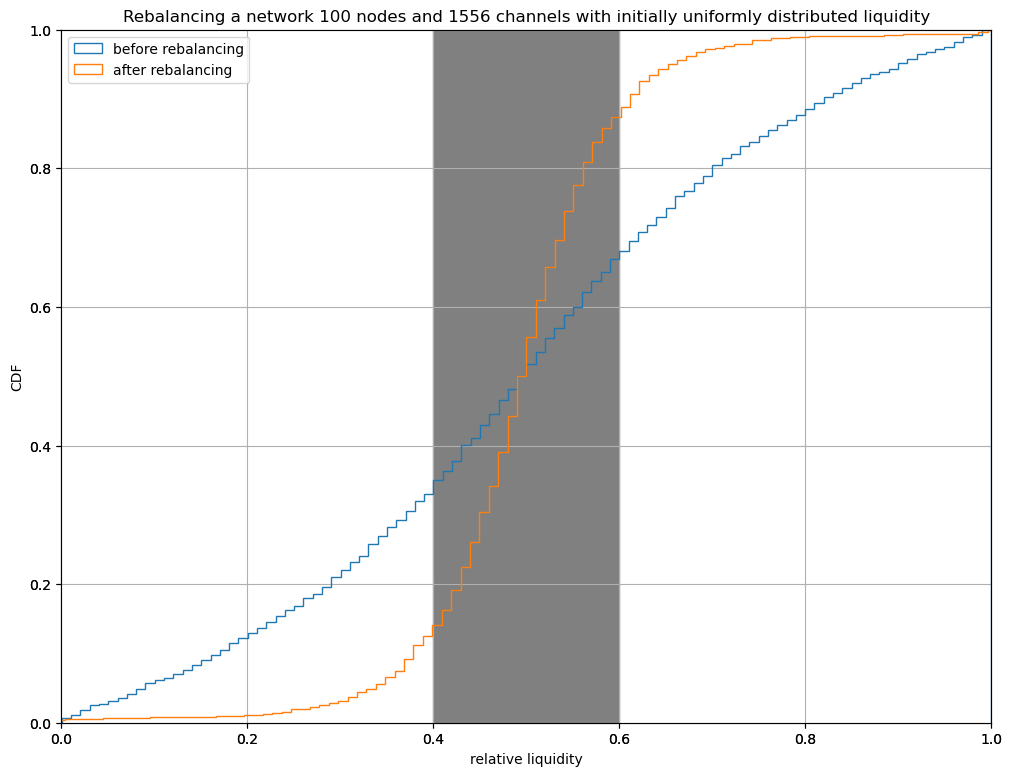

In [18]:
def opt_with_plot(network):
    fig = plt.figure(figsize=(12,9))
    plt.title("Rebalancing a network {} nodes and {} channels with initially uniformly distributed liquidity".format(len(network.graph.nodes()),len(network.graph.edges())))
    ax = fig.add_subplot(111)
    dist = [x for _,x in network.edge_relative_liquidity()]
    print("BEFORE REBALNCING: {:4.2f}% of all channels have between have liquidity between 0.4 and 0.6".format(100.*len([x for x in  dist if abs(x-0.5)  < 0.1])/len(dist)))
    print("and {:4.2f}% of all channels have between have liquidity between 0.1 and 0.9\n".format(100.*len([x for x in  dist if abs(x-0.5)  < 0.4])/len(dist)))

    ax.add_patch(
     patches.Rectangle(
        (0.4, 0.0),
        0.2,
        1,
        fill=True,
         color="grey"
    ) ) 
    plt.ylim(0,1)
    plt.xlim(0,1)
    #plt.Rectangle((0.4,0),100,1000)
    ax.hist(dist,bins=100,density=True,cumulative=True, histtype="step",label="before rebalancing")
    network = optimize_liquidity_graph(network)
    dist = [x for _,x in network.edge_relative_liquidity()]
    print("\nAFTER REBALNCING: {:4.2f}% of all channels have between have liquidity between 0.4 and 0.6".format(100.*len([x for x in  dist if abs(x-0.5)  < 0.1])/len(dist)))
    print("and {:4.2f}% of all channels have between have liquidity between 0.1 and 0.9".format(100.*len([x for x in  dist if abs(x-0.5)  < 0.4])/len(dist)))
    ax.hist(dist,bins=100,density=True,cumulative=True, histtype="step",label="after rebalancing")
    plt.xlabel("relative liquidity")
    plt.ylabel("CDF")
    ax.grid()
    ax.legend()
    plt.show()
    return network

example = opt_with_plot(example)

We can observe the stark effect that the geometric channel replanishment method has on the liquidity distribution in the network. It is also remarkable how much liquiidty is touched and used in the circulation

## Start a simulation of payments

We first make a lot of payments without any rebalancing activated. We will and should see that the network becomes more and more depleted. Note **we arbitrarily call a channel balanced** if and only if its relative liquidity is between 0.4 and 0.6

In [21]:
def simulate_payments_with_wealth(example, num_payments=100, with_rebalancing=True):
    """
    Simulates random payments between nodes and records edge liquidity and wealth over time.

    Parameters:
        example (LiquidityGraph): The liquidity graph object.
        num_payments (int): Number of random payments to simulate.

    Returns:
        tuple: A tuple containing:
            - edge_time_series (dict): A dictionary where keys are edges (u, v), 
                                       and values are lists of liquidity values over time.
            - wealth_time_series (dict): A dictionary where keys are nodes, 
                                         and values are lists of wealth values over time.
    """
    # Initialize time series dictionaries
    #if with_rebalancing:
    #    print("make an initial rebalancing")
    #    example = optimize_liquidity_graph(example)

    
    edge_time_series = {edge: [] for edge in example.graph.edges if edge[0]<edge[1]}
    wealth_time_series = {node: [] for node in example.graph.nodes}

    # Nodes in the graph
    nodes = list(example.graph.nodes)
    total_liquidity = sum(example.graph[u][v]['liquidity'] for u,v in example.graph.edges())
    # Simulate payments
    rb = False
    for i in range(num_payments):
        # Randomly select source and target nodes
        source, target = random.sample(nodes, 2)

        try:
            # Conduct a payment of 1 unit
            example.make_payment(source, target, amount=random.randint(1,3000))
        except ValueError:
            # Skip if the payment fails
            continue

        for j in range(2):
            # Record the current liquidity of all edges
            for edge in example.graph.edges:
                u,v = edge
                if u>v:
                    continue
                uv = example.graph[edge[0]][edge[1]]['liquidity']
                vu = example.graph[edge[1]][edge[0]]['liquidity']
                edge_time_series[edge].append(uv/(uv+vu))
                if edge_time_series[edge][-1] < 0.01:
                    rb = True
            
            # Record the current wealth of all nodes
            for node in example.graph.nodes:
                wealth = sum(
                    example.graph[node][neighbor]['liquidity'] for neighbor in example.graph.neighbors(node)
                )
                wealth_time_series[node].append(wealth/total_liquidity)
            """
            if i%40==39 and j==0 and with_rebalancing:
                print(i)
                example = optimize_liquidity_graph(example)
                #rb = False"""
            dist = [x for _,x in example.edge_relative_liquidity()]
            frac_balanced = len([x for x in  dist if abs(x-0.5)  < 0.1])/len(dist)
            if i % 250  == 0:
                print("after {} payments we have only {:4.2f}% of all channels balanced".format(i, 100*frac_balanced))

            if with_rebalancing and frac_balanced < 0.5:
                print("after {} payments we have only {:4.2f}% of all channels balanced. initiate rebalancing".format(i, 100*frac_balanced))
                #example = opt_with_plot(example)
                example = optimize_liquidity_graph(example)

            else:
                break
                
    return edge_time_series, wealth_time_series


def plot_liquidity_time_series(time_series,title,save_plot_name=None):
    """
    Plots the liquidity time series for every edge in the network.
    
    Parameters:
        time_series (dict): A dictionary where keys are edges (u, v), and values are lists of 
                            liquidity values over time.
    """
    bp = [v for k,v in time_series.items()]
    """
    plt.figure(figsize=(12,9))
    plt.title("Box Plot for liquidity distribution in channels with optimal rebalancing protocol activated")
    plt.boxplot(bp)
    plt.ylabel("relative liquidity")
    plt.xlabel("channels")
    plt.grid()
    if save_plot_name is not None:    
        plt.savefig("rebalancing/compare_bp_"+save_plot_name+".png")
    plt.show()
    """
    median_liquidity = [np.median(x) for x in bp]
    plt.figure(figsize=(12,9))
    plt.title("Median liquidity values of channels during simulation ({})".format(title))
    plt.hist(median_liquidity)
    plt.xlabel("relative liquidity")
    plt.ylabel("# of channels")
    plt.grid()
    plt.show()


## Simulation

We start with a balanced network that before being balanced had its channels with uniformly distributed. From there we conduct payments until the network depletes. we will see that the median liquidity values of channels are centered towards the middle (which reflects the initially balanced network) but two modes also exist towards the depleted ends

after 0 payments we have only 74.04% of all channels balanced
after 250 payments we have only 59.25% of all channels balanced
after 500 payments we have only 48.07% of all channels balanced
after 750 payments we have only 41.52% of all channels balanced
after 1000 payments we have only 36.12% of all channels balanced
after 1250 payments we have only 33.80% of all channels balanced
after 1500 payments we have only 29.69% of all channels balanced
after 1750 payments we have only 27.38% of all channels balanced
after 2000 payments we have only 24.29% of all channels balanced
after 2250 payments we have only 22.11% of all channels balanced
after 2500 payments we have only 21.72% of all channels balanced


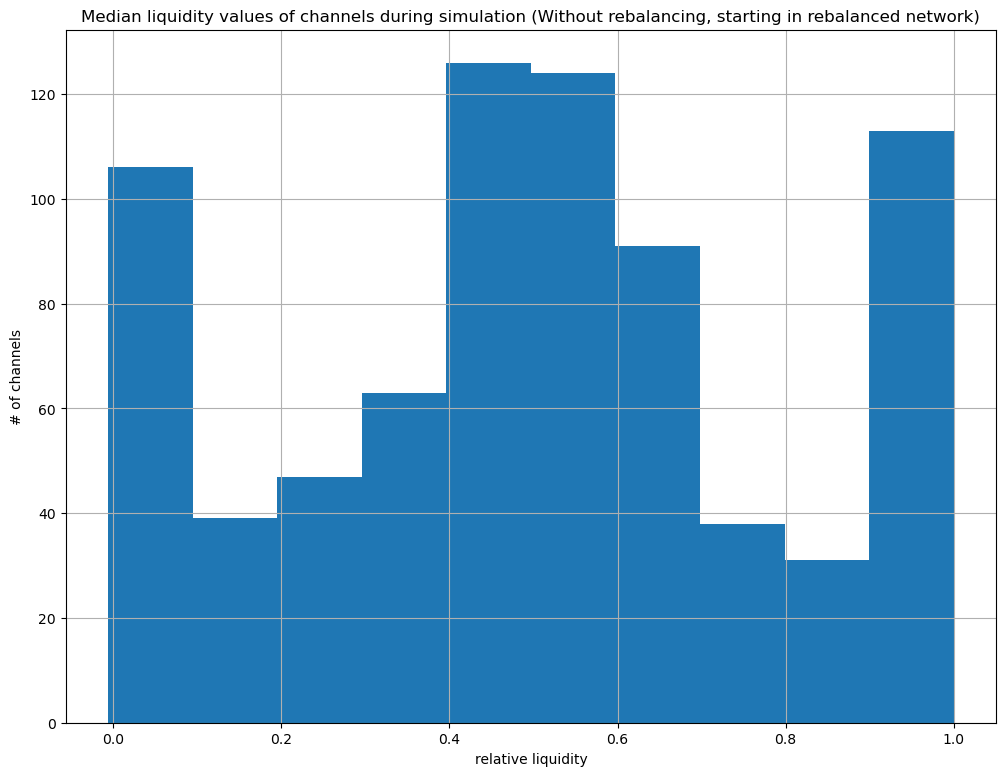

In [24]:
## We conduct 2750 payments within the network and see how the balance changes
ts,w_ts = simulate_payments_with_wealth(example,2750,False)
plot_liquidity_time_series(ts,"Without rebalancing, starting in rebalanced network")

# Continuing payments in the depleted network

Given the network is in a depleted state we reset our time series of liquidity states for visualizing the histograms but continue to make payments. This is done to see the the network is in deed depleted

after 0 payments we have only 20.44% of all channels balanced
after 250 payments we have only 19.54% of all channels balanced
after 500 payments we have only 18.51% of all channels balanced
after 750 payments we have only 17.35% of all channels balanced
after 1000 payments we have only 16.45% of all channels balanced
after 1250 payments we have only 15.04% of all channels balanced
after 1500 payments we have only 14.78% of all channels balanced
after 1750 payments we have only 14.27% of all channels balanced
after 2000 payments we have only 12.21% of all channels balanced
after 2250 payments we have only 12.60% of all channels balanced
after 2500 payments we have only 12.08% of all channels balanced


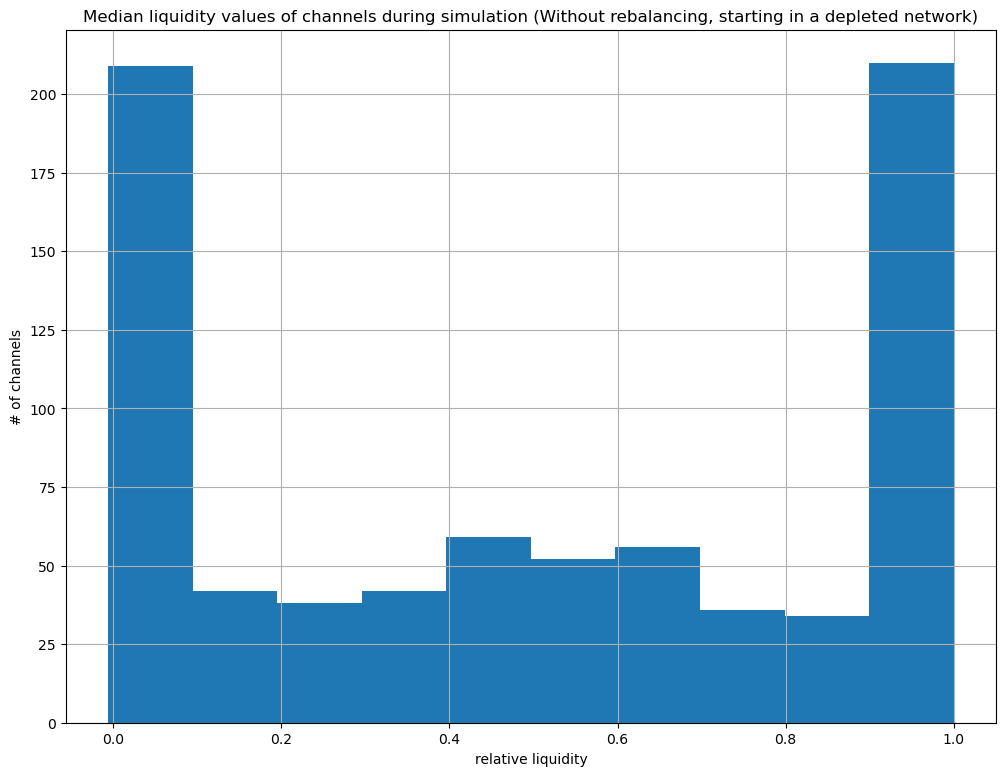

In [27]:
ts,w_ts = simulate_payments_with_wealth(example,2750,False)
plot_liquidity_time_series(ts,"Without rebalancing, starting in a depleted network")


## Activating Channel Replaninshment

Note how before rebalancing many channels have either no or full liquidity on one end. Despite the network being so imbalanced there is an opportunity to replanish channels. We will once solve the optimization problem to see how the liquidity in thenetwork shifts from depleted channels to many channels centered around the desired 50:50 state. Again note that 50:50 was arbitrarily chosen. The wishes of nodes could be respected. In particular as explained this replanishment does not change the wealth distribution

BEFORE REBALNCING: 11.31% of all channels have between have liquidity between 0.4 and 0.6
and 41.52% of all channels have between have liquidity between 0.1 and 0.9


Optimal continous solution x_r has has distance 91092.32 to x0.
Feasible but non optimal integer solution x has a distance of 91096.86 to x0.

rebalanced: 5170648.0 coins which is 33.23% of the total capacity

AFTER REBALNCING: 56.30% of all channels have between have liquidity between 0.4 and 0.6
and 95.24% of all channels have between have liquidity between 0.1 and 0.9


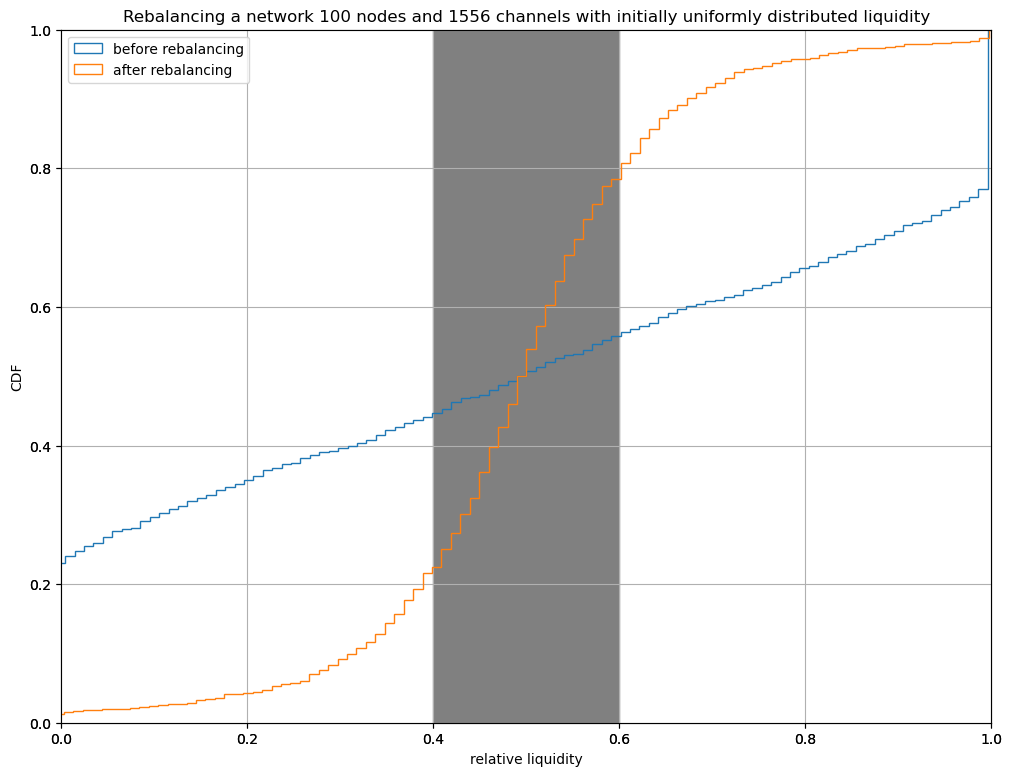

In [30]:
example = opt_with_plot(example)


## Payment simulation with activated replanishment

We conduct a simulation of payments and chose to replannish channels if too many channels become imbalanced. Again we track the liquidity state of channel over time during the simulation. One can see in the log that the network rebalances occasionaly after sufficient amount of payments have created to many imbalanced channels. In particular the histogram will show how the median liquidity in channels over time was centered around the middle - which is a stark contrast to the preliminary experiments where those median values where in a depleted state

In [33]:
ts,w_ts = simulate_payments_with_wealth(example,2750,True)

after 0 payments we have only 56.17% of all channels balanced
after 128 payments we have only 49.87% of all channels balanced. initiate rebalancing

Optimal continous solution x_r has has distance 90594.28 to x0.
Feasible but non optimal integer solution x has a distance of 90598.04 to x0.

rebalanced: 636905.0 coins which is 4.09% of the total capacity
after 250 payments we have only 51.29% of all channels balanced
after 269 payments we have only 49.87% of all channels balanced. initiate rebalancing

Optimal continous solution x_r has has distance 91716.19 to x0.
Feasible but non optimal integer solution x has a distance of 91719.99 to x0.

rebalanced: 680786.0 coins which is 4.37% of the total capacity
after 414 payments we have only 49.74% of all channels balanced. initiate rebalancing

Optimal continous solution x_r has has distance 92253.64 to x0.
Feasible but non optimal integer solution x has a distance of 92256.84 to x0.

rebalanced: 648303.0 coins which is 4.17% of the total c

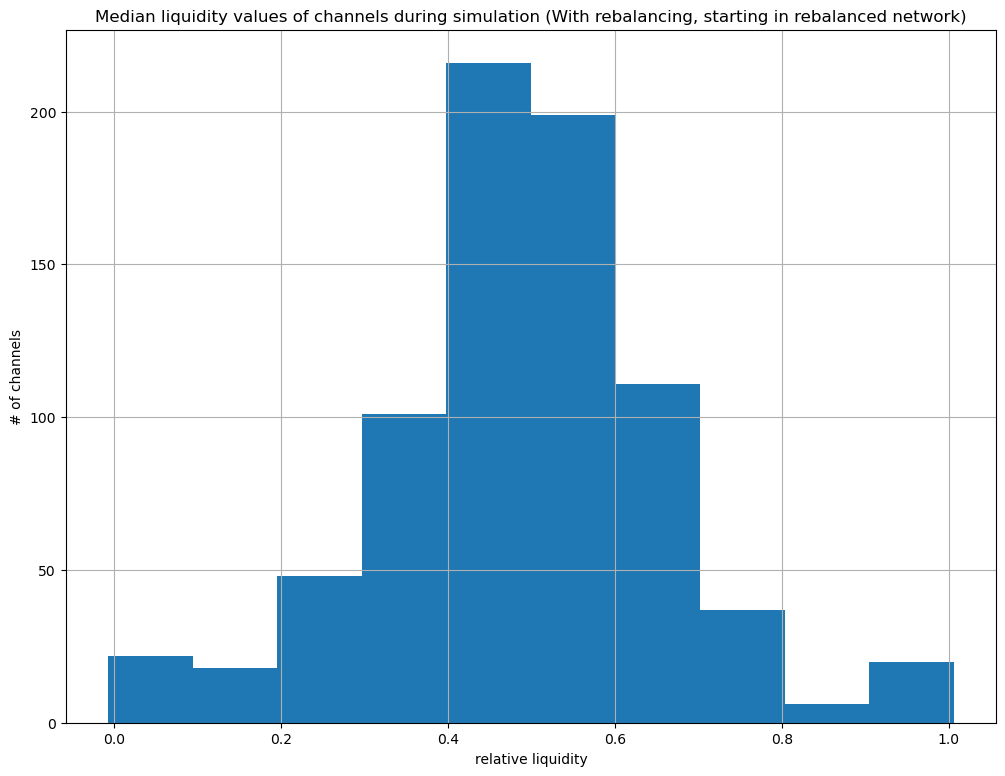

In [35]:
plot_liquidity_time_series(ts,"With rebalancing, starting in rebalanced network")

### Excluded scenario
Note that in a future study we may select a target state that at least reflects the wealth distribution - id est nodes can only makes wishes in their channels for the liquidity they own - however this may still lead to a situation where two nodes `A` and `B` own a channel of `100k` sats but `A` might only wish to own `10k` sats in that channel and `B` might not wish to own `90k` sats on that channel. Thus even if liquidity wishes reflect local liquidity there may not be a feasible state that reflects all the liquidity wishes.

